#  **Final Project - Demographic Analysis of the Academy Award Nominations**
*Notebook V*

The Academy Award Demographics dataset - Winners network

---

> Authors: Sara Kartalovic, Bogdan Milovanovic,  Tarja Savonen<br>
> Date: 19/01/2022 <br>
> Course : Network Science <br>
> Teacher : Tomaso Erseghe <br>
> Co-Teachers : Lejla Dzanko

In [1]:
# Imports

import os
import pandas as pd
import numpy as np
import math as math
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 

import itertools
import networkx as nx

from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
# Mount Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def degree_freq(G, degree_direction):
    n_nodes = len(G.nodes)
    if degree_direction=='in':
        k_list = np.array([G.in_degree[i] for i in range(n_nodes)])
    elif degree_direction=='out':
        k_list = np.array([G.out_degree[i] for i in range(n_nodes)])
    else:
        k_list = np.array([val for (node, val) in G.degree()])
        
    dmax=max(k_list)+1
    freq= [ 0 for d in range(dmax) ] #[0,0,0,,,,,,0]
    for d in k_list:
        freq[d] += 1
    return (freq, k_list)

plt.show()

def plot_plot(G, degree_direction):
    freq, k_list = degree_freq(G, degree_direction)
       
    mean_degree = round(np.mean(k_list),3) # mean value of degree list
    std_degree = round(np.std(k_list),3) # stdev of degree list
    figure(figsize=(7, 5))

    plt.plot(range(len(freq)),freq, '.')
    plt.xticks(range(0,max(k_list),5))
    plt.xlabel(degree_direction+"-degree, $K_{%s}$"%degree_direction,size=12)
    plt.ylabel('Number of nodes',size=12)
    plt.title(degree_direction+'-degree distribution, $P_{k_{%s}}$'%degree_direction,size=14)
    s = 'n_nodes: '+str(len(k_list))+'\nMean degree: '+str(mean_degree)+'\nSTDEV degree: '+str(std_degree)
    
    # some useful tricks to plot text in the place of legend!!
    plt.plot([],[],label=s)
    legend = plt.legend(handlelength=0, handletextpad=0, fancybox=True,loc='best')
    plt.show()


def logPk(logk,logc,gamma):
    return logc - gamma*logk

def plotnfit_Pk(G, degree_direction):    
    freq, k_list = degree_freq(G, degree_direction)
    # k is list of all the degrees present.
    
    k_initial = 50 #we reject all K < K_initial
    # k= [80.....475] for in degree. 
    k = np.array(range(k_initial,max(k_list)+1)) # applying assumption
    # consider only the frequencies for K>=80 where freq=counts for k values of (0,1,2,3,....) in that order
    Pk = np.array(freq[k_initial:])

    # remove zeros from Pk, clean the data since we are applying log function.
    Pk_new = Pk[Pk>0] #Pk[True, True, False, .......]
    # remove all degrees that have 0 frequency
    k_new = k[Pk>0]

    # apply log to do log fitting instead of power law fitting
    x = np.log(k_new)
    y = np.log(Pk_new)
    params,cov = curve_fit(logPk,x,y) # cov is the covariance matrix
    logc = params[0]
    gamma = params[1]

    y_fit = logPk(x,*params)

    figure(figsize=(7, 5))

    plt.loglog(range(len(freq)), freq, '.')
    plt.loglog(np.exp(x),np.exp(y_fit))
    
    # aesthetics
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.grid(linestyle='--',alpha=0.5)
    
    # print info on the graph
    s = 'Reject all K < '+str(k_initial)+'\n$\gamma = $ '+str(round(gamma,3))+'\nlog(C) = '+str(round(logc,3))
    # some useful tricks to plot text in the place of legend!!
    plt.plot([],[],label=s)
    legend = plt.legend(handlelength=0, handletextpad=0, fancybox=True,loc='best')
    
    plt.xlabel(degree_direction+"-degree, $k_{%s}$"%degree_direction,size=12)
    plt.ylabel("$P_{k_{%s}}$"%degree_direction,size=12)
    plt.title('log-log plot of %s-degree distribution \nand fit $P_{k_{%s}} = C  K^{-\gamma}_{%s}$'
              %(degree_direction,degree_direction,degree_direction),size=14)
    
    plt.show()

def plot_degree_distr(G, degree_direction):
    plt.figure()
    
    plt.subplot(1,2,1)
    plot_barplot(G, degree_direction)
    
    plt.subplot(1,2,2)
    plotnfit_Pk(G, degree_direction)
    
    #plt.tight_layout()
    plt.show()

In [4]:
demographics = pd.read_csv('/content/drive/MyDrive/NS/Original Filtered Data/Oscars-demographics-DFE.csv')

In [5]:
demographics = demographics.replace('Na', np.nan)

In [6]:
usa_eng_df = demographics.loc[(demographics['birthplace'] == 'England') | (demographics['birthplace'] == 'USA')]
usa_eng = usa_eng_df['birthplace']
for country in demographics['birthplace']:
  if country != 'USA':
    if country != 'England':
      demographics['birthplace'] = demographics['birthplace'].replace(country, 'Other')

usa_eng_df = demographics.loc[(demographics['sexual_orientation'] == 'Lesbian') | (demographics['sexual_orientation'] == 'Gay')]
usa_eng = usa_eng_df['sexual_orientation']
for country in demographics['sexual_orientation']:
  if country != 'Straight':
    if country != 'Bisexual':
      demographics['sexual_orientation'] = demographics['sexual_orientation'].replace(country, 'Gay/Lesbian')

In [7]:
del demographics['religion']
demographics = demographics.dropna()

# Building Network

In [8]:
df = demographics[['person', 'birthplace']]

In [9]:
unique_people = {}

for idx, row in demographics.iterrows():
  people = [row['person']]
  for person in people:
    if people != '0':
      unique_people.setdefault(person,0)
      unique_people[person] += 1

up_df = pd.DataFrame.from_dict(unique_people, orient='index').reset_index()
up_df.rename(columns = {'index':'Company', 0:'Count'}, inplace=True)

In [10]:
# Create dictionary- {film: list of actors}

#initialize an empty dict
name_place_dict = {}

for idx, row in df.iterrows():
#for row in oscar.film:
  people = [row['person']]
  places = [row['birthplace']]

  for person in people:
    for place in places:
      #if the word is encountered for the first time add to dict as key and set its value to 0
      if person not in name_place_dict.keys():
        name_place_dict.setdefault(person,[place])
      else:
        name_place_dict[person].append(place)

In [20]:
# Create network

G = nx.Graph()
edge_attribute_dict = {}

for name, places in name_place_dict.items():
  G.add_node(name)
  for place in places:
    for name2, places2 in name_place_dict.items():
      if (place in places2) and (places2 != places):
        G.add_edge(name, name2)
        name_tuple = tuple(sorted((name, name2)))
        if name_tuple not in edge_attribute_dict:
          edge_attribute_dict.setdefault(name_tuple,0)
        else:
          edge_attribute_dict[name_tuple] +=1

In [21]:
# Create dataframe from dictionary
name_places_df = pd.DataFrame.from_dict(name_place_dict, orient='index').reset_index()
name_places_df.rename(columns= {'index':'Name'}, inplace= True)
name_places_df = name_places_df.fillna('0')

In [13]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edges, weigth in edge_attribute_dict.items():
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edges[0],edges[1],weigth))

G.add_weighted_edges_from(up_weighted)

In [14]:
print(nx.info(G))

Graph with 348 nodes and 10476 edges


In [15]:
np_df = name_places_df.copy()
np_df.drop(columns=[column for column in np_df.columns if column!='Name'], inplace=True)
np_df.rename(columns={'Name':'Label'}, inplace=True)
np_df["Id"] = np_df["Label"]
np_df.sort_values(by = 'Label', inplace = True)

In [16]:
race = demographics[['person', 'race_ethnicity']]
race.sort_values(by = 'person', inplace = True)

sex_orient = demographics[['person', 'sexual_orientation']]
sex_orient.sort_values(by = 'person', inplace = True)

nodes_race_df = pd.merge(
    left = np_df,
    right = race, how = 'left', left_on='Label', right_on= 'person')

nodes_race_sex_att_df = pd.merge(
    left = nodes_race_df,
    right = sex_orient, how = 'left', left_on='Label', right_on= 'person')

del nodes_race_sex_att_df['person_x']
del nodes_race_sex_att_df['person_y']

nodes_race_sex_att_df = nodes_race_sex_att_df.drop_duplicates('Label')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# Save edges
nx.write_weighted_edgelist(G, "./name_place_edgelist.csv", delimiter=",")

# Save nodes
att_df = nodes_race_sex_att_df.copy()
att_df.to_csv("name_place_nodelist_race_sex_att.csv")

# Network Analysis


## Degree distribution

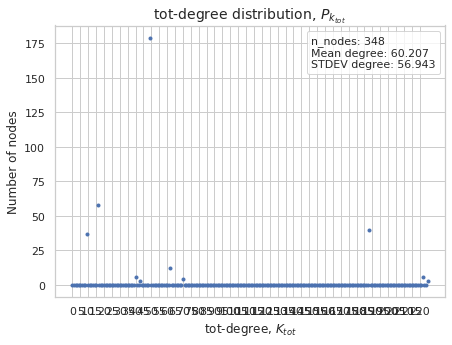

In [ ]:
plot_plot(G,'tot')

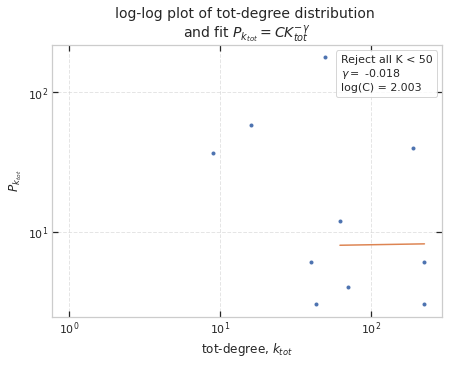

In [ ]:
plotnfit_Pk(G,'tot')

## Shorthest Path (NO WEIGHTS)

(0.0, 3.0)

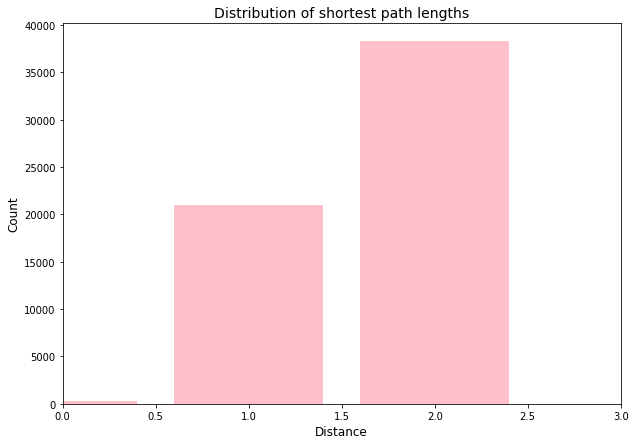

In [23]:
# Find path lengths
length_source_target = dict(nx.shortest_path_length(G, weight = 'weight'))

# Convert dict of dicts to flat list
all_shortest = sum([
list(length_target.values())
for length_target
in length_source_target.values()],
[])
# Calculate integer bins
high = max(all_shortest)
bins = [-0.5 + i for i in range(high + 2)]

# Plot histogram
plt. figure(figsize=(10,7))
plt.hist(all_shortest, bins=bins, rwidth=0.8, color = 'pink')
plt.title("Distribution of shortest path lengths", size=14)
plt.xlabel("Distance", size=12)
plt.ylabel("Count", size=12)
plt.xlim(0,3)

## Centrality measurements

### Page Rank

In [ ]:
page_rank = nx.pagerank(G, alpha = 0.8, weight = 'weight') 

sorted_page_rank = sorted(page_rank.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by Page rank:")
for b in sorted_page_rank[:20]:
    print(b)

Top 10 nodes by Page rank:
('Daniel Day-Lewis', 0.0074403934320465895)
('Elizabeth Taylor', 0.0074403934320465895)
('Maggie Smith', 0.0074403934320465895)
('John Ford', 0.007311170049170581)
('Katharine Hepburn', 0.007311170049170581)
('Hilary Swank', 0.007311170049170581)
('Gary Cooper', 0.007232752777678389)
('Jack Nicholson', 0.007232752777678389)
('Tom Hanks', 0.007232752777678389)
('Walter Brennan', 0.007232752777678389)
('Jason Robards', 0.007232752777678389)
('Meryl Streep', 0.007232752777678389)
('David Lean', 0.007013915280846644)
('Danny Boyle', 0.007013915280846644)
('Peter Ustinov', 0.007013915280846644)
('Michael Caine', 0.007013915280846644)
('Glenda Jackson', 0.007013915280846644)
('Rachel Weisz', 0.007013915280846644)
('Frank Capra', 0.006990318374344142)
('William Wyler', 0.006990318374344142)


### Betweenness centrality

In [ ]:
betweenness_dict = nx.betweenness_centrality(G, weight = 'weight') # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G, weight = 'weight') # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [ ]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b)

Top 10 nodes by betweenness centrality:
('John Ford', 0.005486148035471178)
('Katharine Hepburn', 0.005486148035471178)
('Hilary Swank', 0.005486148035471178)
('Gary Cooper', 0.005485244598343123)
('Jack Nicholson', 0.005485244598343123)
('Tom Hanks', 0.005485244598343123)
('Walter Brennan', 0.005485244598343123)
('Jason Robards', 0.005485244598343123)
('Meryl Streep', 0.005485244598343123)
('Leo McCarey', 0.005417256915268624)


In [ ]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b)

Top 10 nodes by eigenvector centrality:
('John Ford', 0.13391074315632207)
('Katharine Hepburn', 0.13391074315632207)
('Hilary Swank', 0.13391074315632207)
('Gary Cooper', 0.13021026257255103)
('Jack Nicholson', 0.13021026257255103)
('Tom Hanks', 0.13021026257255103)
('Walter Brennan', 0.13021026257255103)
('Jason Robards', 0.13021026257255103)
('Meryl Streep', 0.13021026257255103)
('Leo McCarey', 0.09915577882147225)


### Closeness Centrality

In [ ]:
close_centrality = nx.closeness_centrality(G) #does not need weights

sorted_centrality = sorted(close_centrality.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by closeness centrality:")
for d in sorted_centrality[:10]:
    print(d)

Top 10 nodes by closeness centrality:
('John Ford', 0.6484653234838856)
('Katharine Hepburn', 0.6484653234838856)
('Hilary Swank', 0.6484653234838856)
('Gary Cooper', 0.6400799960250423)
('Jack Nicholson', 0.6400799960250423)
('Tom Hanks', 0.6400799960250423)
('Walter Brennan', 0.6400799960250423)
('Jason Robards', 0.6400799960250423)
('Meryl Streep', 0.6400799960250423)
('Leo McCarey', 0.5582652596910144)


In [ ]:
closeness = pd.DataFrame.from_dict(sorted_centrality) #closeness centrality
closeness.columns =['Node', 'Closeness centrality'] 
closeness['Closeness centrality'] = (closeness['Closeness centrality'] - min(closeness['Closeness centrality']))/(max(closeness['Closeness centrality'])- min(closeness['Closeness centrality']))

eigenvec = pd.DataFrame.from_dict(sorted_eigenvector)
eigenvec.columns =['Node', 'Eigenvector centrality'] 
eigenvec['Eigenvector centrality'] = (eigenvec['Eigenvector centrality'] - min(eigenvec['Eigenvector centrality']))/(max(eigenvec['Eigenvector centrality'])- min(eigenvec['Eigenvector centrality']))


betweenness = pd.DataFrame.from_dict(sorted_betweenness)
betweenness.columns =['Node', 'Betweenness centrality'] 
betweenness['Betweenness centrality'] = (betweenness['Betweenness centrality'] - min(betweenness['Betweenness centrality']))/(max(betweenness['Betweenness centrality'])- min(betweenness['Betweenness centrality']))

page_rank = pd.DataFrame.from_dict(sorted_page_rank)
page_rank.columns =['Node', 'Page Rank centrality'] 
page_rank['Page Rank centrality'] = (page_rank['Page Rank centrality'] - min(page_rank['Page Rank centrality']))/(max(page_rank['Page Rank centrality'])- min(page_rank['Page Rank centrality']))

closeness = closeness[0:5]
eigenvec = eigenvec[0:5]
betweenness = betweenness[0:5]
page_rank = page_rank[0:5]

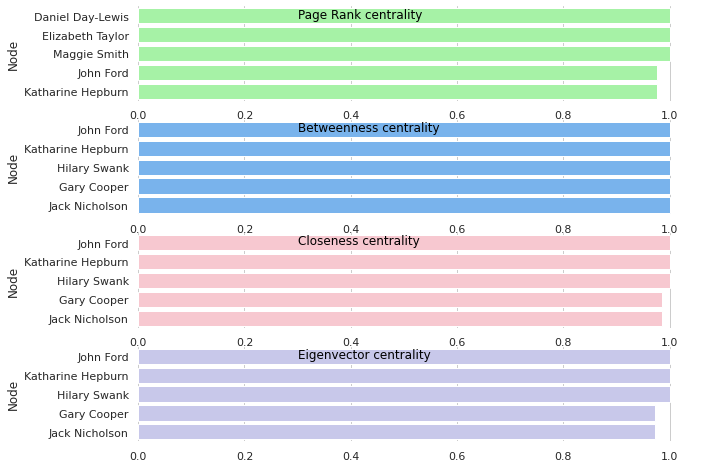

In [ ]:
# Initialize the matplotlib figure

fig, (ax3, ax4, ax5, ax6) = plt.subplots(4,figsize=(10, 8) )

sns.set(style="whitegrid")

sns.barplot(x='Closeness centrality', y="Node",data=closeness,
            color="pink", orient = 'h',order=closeness.sort_values('Closeness centrality', ascending=False)['Node'] , ax = ax5)
ax5.text(0.3, 0.1,'Closeness centrality', c = "Black")
ax5.xaxis.label.set_visible(False)

sns.barplot(x='Eigenvector centrality', y="Node",data=eigenvec,
            color='#c2c2f0', orient = 'h',order=eigenvec.sort_values('Eigenvector centrality', ascending=False)['Node'] , ax = ax6)
ax6.text(0.3, 0.10,'Eigenvector centrality', c = "Black")
ax6.xaxis.label.set_visible(False)

sns.barplot(x= 'Betweenness centrality', y="Node",data=betweenness,
            color='#66b3ff', orient = 'h',order=betweenness.sort_values('Betweenness centrality', ascending=False)['Node'] , ax = ax4)
ax4.text(0.3, 0.10,'Betweenness centrality', c = "Black")
ax4.xaxis.label.set_visible(False)

sns.barplot(x='Page Rank centrality', y="Node",data=page_rank,
            color="#99ff99", orient = 'h',order=page_rank.sort_values('Page Rank centrality', ascending=False)['Node'] , ax = ax3)
ax3.text(0.3, 0.10,'Page Rank centrality', c = "Black")
ax3.xaxis.label.set_visible(False)

sns.despine(left=True, bottom=True)

### Transitivity

In [ ]:
random_graph = nx.fast_gnp_random_graph(len(G.nodes), 0.1)

In [ ]:
nx.transitivity(random_graph)

0.10382682784736383

In [ ]:
triadic_closure = nx.transitivity(G) #Does not need weights
print("Triadic closure:", triadic_closure)

Triadic closure: 0.18193868341490474


In [ ]:
clustering = nx.clustering(G, weight= 'weight')
print(clustering)

{'Lewis Milestone': 0.12268640930724485, 'Frank Capra': 0.28819875776397513, 'William Wyler': 0.28819875776397513, 'Michael Curtiz': 0.4, 'Billy Wilder': 0.28819875776397513, 'Mike Nichols': 0.4, 'Franklin J. Schaffner': 0.4, 'Bernardo Bertolucci': 0.4, 'James Cameron': 0.4, 'Roman Polanski': 0.4, 'Peter Jackson': 0.4, 'Michel Hazanavicius': 0.4, 'Emil Jannings': 0.4, 'Paul Muni': 0.4, 'Paul Lukas': 0.4, 'Ray Milland': 0.4, 'Jose Ferrer': 0.4, 'Yul Brynner': 0.4, 'Maximilian Schell': 0.4, 'Anthony Hopkins': 0.4, 'Geoffrey Rush': 0.4, 'Roberto Benigni': 0.4, 'Russell Crowe': 0.4, 'Jean Dujardin': 0.4, 'Joseph Schildkraut': 0.4, 'Barry Fitzgerald': 0.4, 'Harold Russell': 0.4, 'Edmund Gwenn': 0.4, 'Walter Huston': 0.4, 'George Sanders': 0.4, 'Hugh Griffith': 0.4, 'John Houseman': 0.4, 'Haing S. Ngor': 0.4, 'Sean Connery': 0.4, 'Benicio Del Toro': 0.4, 'Javier Bardem': 0.4, 'Heath Ledger': 0.4, 'Christian Bale': 0.4, 'Christopher Plummer': 0.4, 'Mary Pickford': 0.4, 'Norma Shearer': 0.4, '

In [ ]:
avg_clustering = nx.average_clustering(G, weight= 'weight')
print(avg_clustering)

0.31632125845349696


In [ ]:
nx.average_clustering(random_graph, weight= 'weight')

0.1038827555510198